In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,\
GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style = 'white', context = 'notebook', palette = 'deep')

In [3]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
IDtest = test["PassengerId"]

이상치 탐지<br>

In [4]:
#Outlier Detection

def detect_outliers(df, n, features):
    '''
    n보다 더 많은 이상치를 가지고 있는 인덱스를 반환함
    '''
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25) #percentile : 사분위수 계산기
        Q3 = np.percentile(df[col], 75) #25, 50, 75 : Q1, Q2, Q3
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | 
                             (df[col] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col) #이상치인 index 저장
        
    outlier_indices = Counter(outlier_indices) #이상치를 갖는 컬럼의 개수를 찾기
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])
# 이상치를 갖는 컬럼이 2개 이상인 것을 제거    

<h4> 이상치를 갖는 컬럼은 결과를 예측하는 데 영향을 끼침 (특히 회귀 문제) </h4>
- Tukey method를 이용해서 이상치를 감지함 

In [5]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


얻은 인사이트<hr>
<ul>
    <li> 10개의 이상치 중 28, 89, 342는 요금이 이상치였음</li>
    <li> 나머지 7개는 SibSp에 이상치가 있음</li>
</ul>

In [6]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)

In [7]:
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis = 0).reset_index(drop = True)

In [8]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum() #Survived column은 test에 없기 때문에 조인 과정에서 nan

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


<h3> Feature analysis</h3>

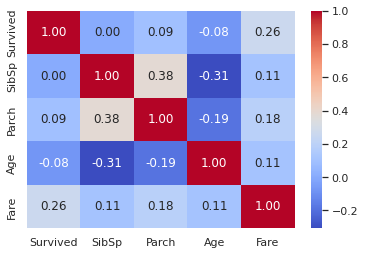

In [12]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

얻은 인사이트<br>
Fare만 Survival과의 상관관계가 보임<br>
상관관계가 보인다는 것이지, 다른 피쳐가 안 중요하다는 것이 아님!!!!!!

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


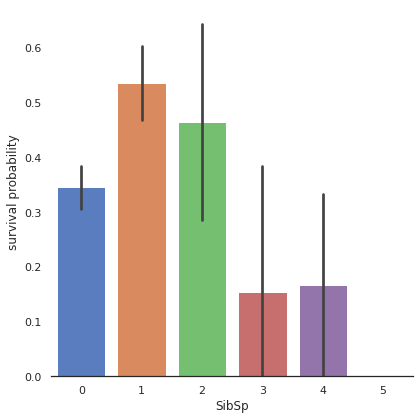

In [13]:
#factorplot => 각 요소마다 survival이 어느 정도 되는가?
g = sns.factorplot(x = "SibSp", y = "Survived", data = train, kind = "bar", size = 6, palette = "muted")
g.despine(left = True) #왼쪽과 오른쪽의 선을 없애버림
g = g.set_ylabels("survival probability")

얻은 인사이트<br>
<ul>
    <li>많은 형제자매가 있으면 더 낮은 확률로 살아남음</li>
    <li>거의 대부분 SibSp가 0, 1, 2인 경우에 더 많은 찬스로 살아남음</li>
</ul>
이 조건들을 이용하여 새로운 파생변수를 생성할 수 있을 것 같음

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


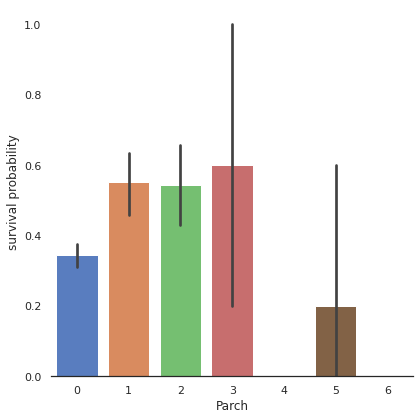

In [14]:
g = sns.factorplot(x = "Parch", y = "Survived", data = train, kind = "bar", size = 6, palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


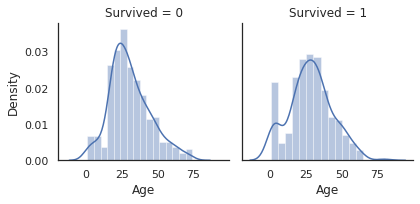

In [15]:
g = sns.FacetGrid(train, col = 'Survived') #Facetgrid => 여러 개의 grid plot을 그릴 수 있고, 범주형 변수에 한해서 그
g = g.map(sns.distplot, 'Age')

여기서 알 수 있는게, survived = 0인 경우의 Age 분포와 survived = 1인 경우의 Age분포가 다름. <br>
실제로 보면, survived = 1에 young people의 생존 비율이 높은 것을 확인할 수 있음

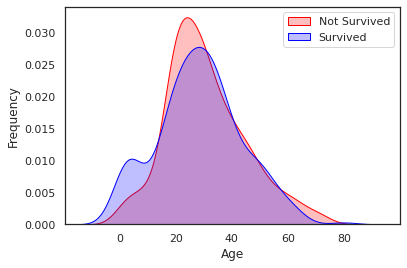

In [16]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax = g, color = 'Blue', shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

나이가 0~5인 아이들의 생존 비율이 peak인 것을 볼 수 잇음 => 얻은 인사이트

In [17]:
dataset['Fare'] = dataset["Fare"].fillna(dataset['Fare'].median())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


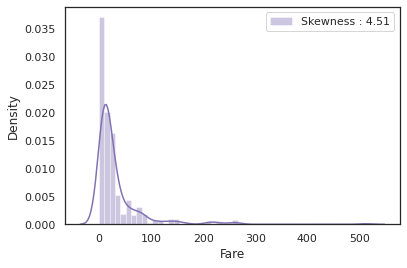

In [18]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = "best")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


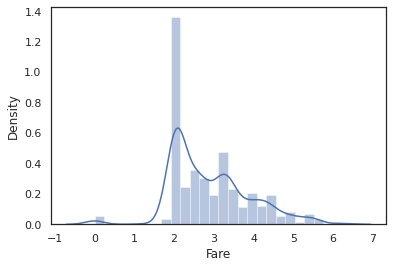

In [19]:
# Fare 컬럼의 skewness가 너무너무 심해서 log화로 skewness를 없앰

dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i > 0 else 0)
g = sns.distplot(dataset['Fare'], color = 'b', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))

<h3> Categorical Values</h3>

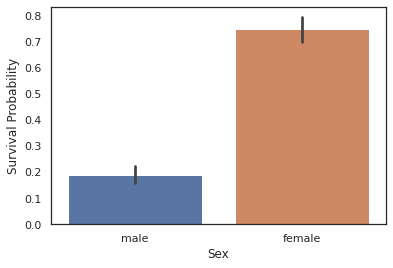

In [20]:
g = sns.barplot(x = "Sex", y = "Survived", data = train)
g = g.set_ylabel('Survival Probability')

In [21]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


성별 -> 여성의 생존 비율이 압도적으로 많음 => 성별은 0, 1을 분류하는 데 있어서 중요한 역할을 하는 변수임

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


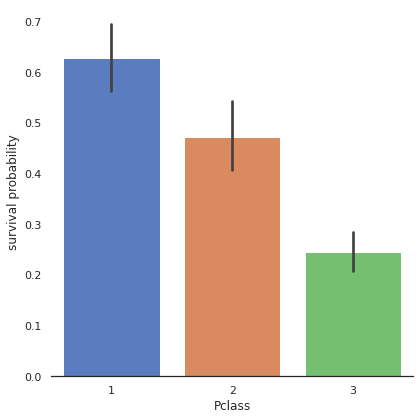

In [22]:
g = sns.factorplot(x = "Pclass", y = "Survived", data = train, kind = "bar", size = 6,
                  palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


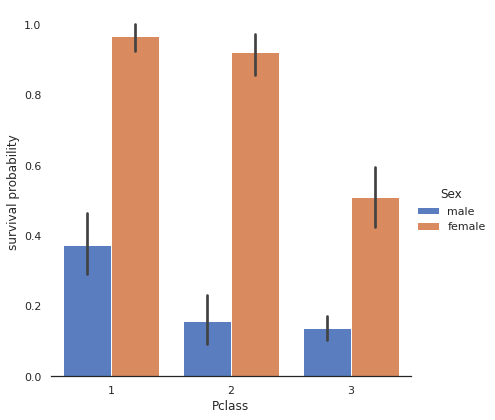

In [23]:
g = sns.catplot(x = "Pclass", y = "Survived", hue = "Sex", data = train,
                  size = 6, kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

여기서도 알 수 있는 것은 Pclass에 따라서, 사람들의 생존율이 달라졌다.

In [24]:
dataset['Embarked'] = dataset['Embarked'].fillna('S') # 최빈값 대체

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


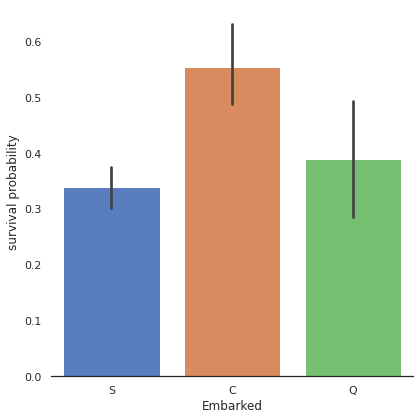

In [25]:
g = sns.factorplot(x = "Embarked", y = "Survived", data = train,
                  size = 6, kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

Embarked가 C인 사람들의 생존 비율이 높음<br>
가설 : Pclass가 1인 사람들은 Embarked가 C일 것이다.(C인 곳에서 승선했을 것이다)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


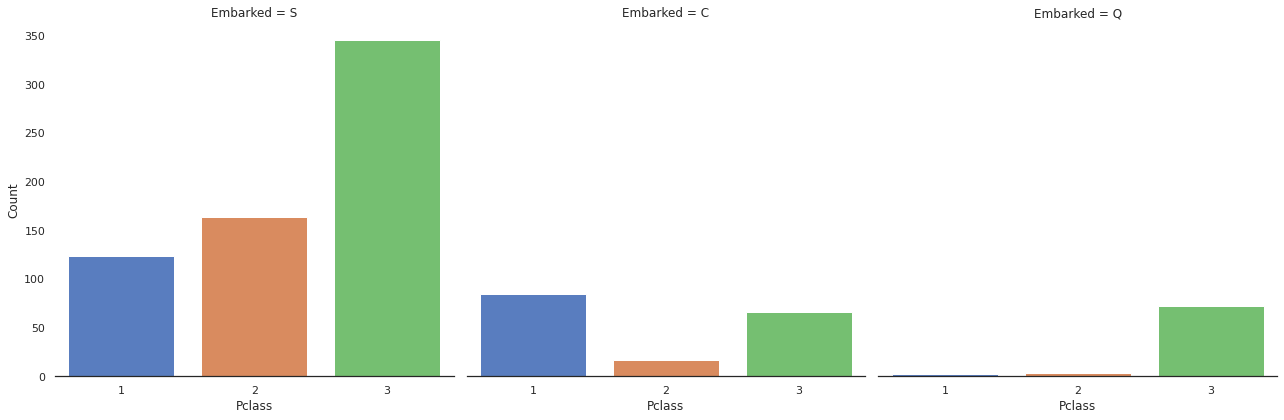

In [26]:
#각 Pclass별 Embarked가 몇 명이 있는 지를 확인하는 것이 중요함
g = sns.factorplot("Pclass", col = "Embarked", data = train, size = 6,
                  kind = 'count', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels("Count")

Embarked가 S인 사람의 대부분이 Pclass가 3, C인 사람의 대부분이 Pclass가 1임

<h3> 결측치 처리 </h3>

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt

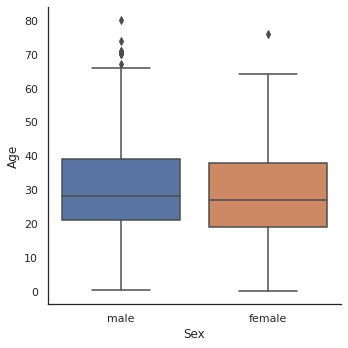

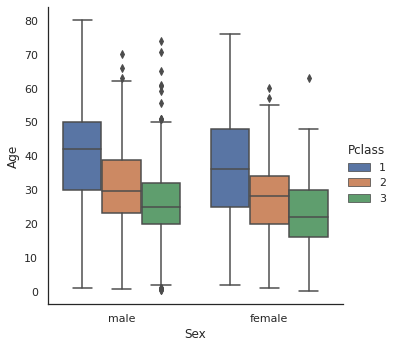

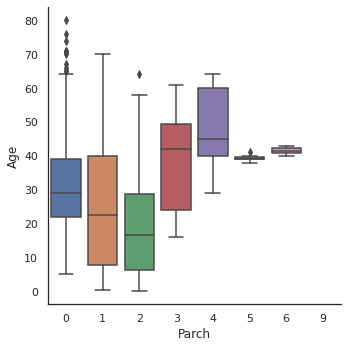

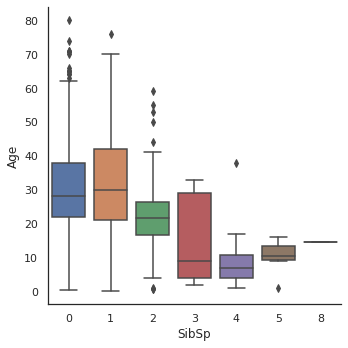

In [27]:
g = sns.factorplot(y = "Age", x = "Sex", data = dataset, kind = "box")
g = sns.factorplot(y = "Age", x = "Sex", hue = 'Pclass', data = dataset, kind = "box")
g = sns.factorplot(y = "Age", x = "Parch", data = dataset, kind = "box")
g = sns.factorplot(y = "Age", x = "SibSp", data = dataset, kind = "box")

얻은 인사이트<br>
1. sex는 남자나 여자 모두 비슷한 형태의 분포를 띄니까 결측치를 처리하는 데 있어 덜 중요한 듯
2. 그러나 성별에다가 Pclass까지 고려한다면, Pclass가 1인 사람일수록 나이가 더 많음

In [28]:
dataset['Sex'] = dataset['Sex'].map({'male' : 0, 'female' : 1})

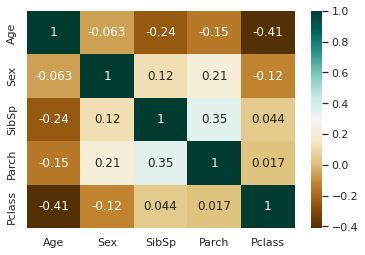

In [29]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap ='BrBG',
               annot = True)

In [30]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) &
                              (dataset['Parch'] == dataset.iloc[i]['Parch']) &
                              (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


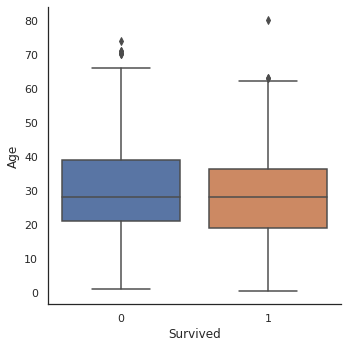

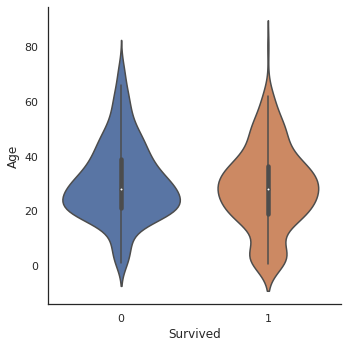

In [31]:
g = sns.factorplot(x = 'Survived', y = 'Age', data = train, kind = 'box')
g = sns.factorplot(x = 'Survived', y = 'Age', data = train, kind = 'violin')

violin plot에서 보면 younger 할수록 survived = 1의 비율이 돋보임

<h3> Feature engineering </h3>

In [32]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [33]:
#split하면 index 1에 mr, mrs 정보 있음
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

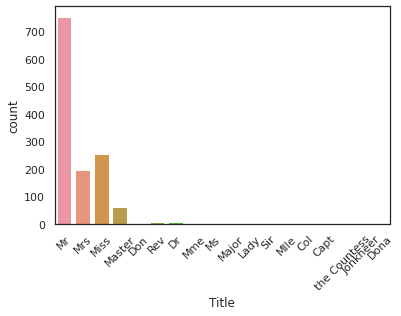

In [34]:
g = sns.countplot(x = "Title", data = dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

In [35]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


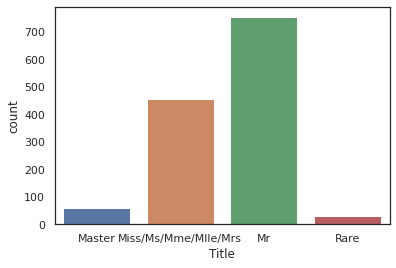

In [36]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


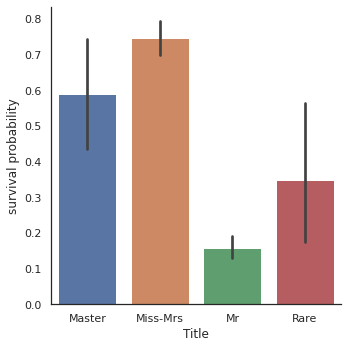

In [37]:
g = sns.factorplot(x = "Title", y = "Survived", data = dataset, kind = "bar")
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

In [38]:
dataset.drop(labels = ['Name'], axis = 1, inplace = True)

<h3> Family size 파생변수 </h3>



In [39]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


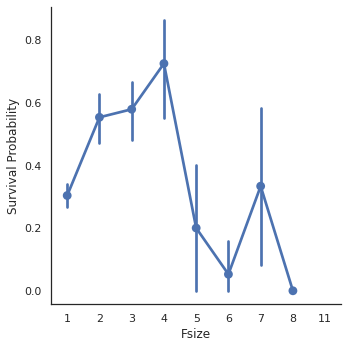

In [40]:
g = sns.factorplot(x = 'Fsize', y = 'Survived', data = dataset)
g = g.set_ylabels('Survival Probability')

familysize가 4일 때가 peak임. familysize가 중요한 변수가 될 거 같음

In [41]:
dataset['Single'] = dataset['Fsize'].map(lambda s : 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s : 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s : 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s : 1 if s >= 5 else 0)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt

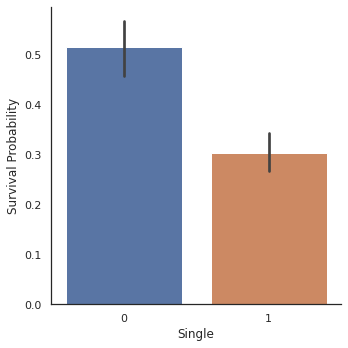

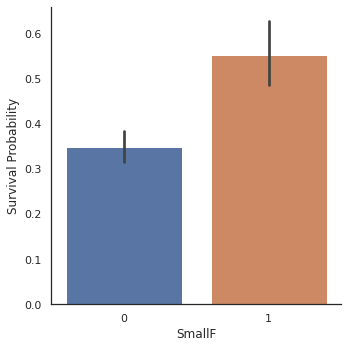

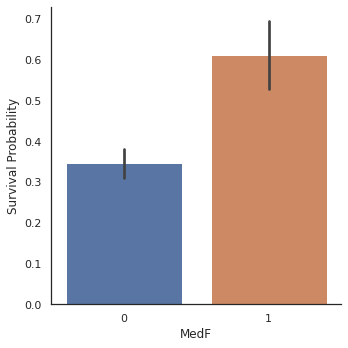

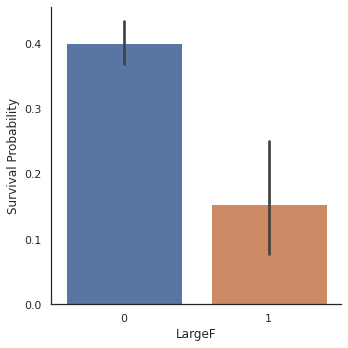

In [42]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [43]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [44]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [45]:
dataset['Cabin'].isnull().sum()

1007

In [46]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [47]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


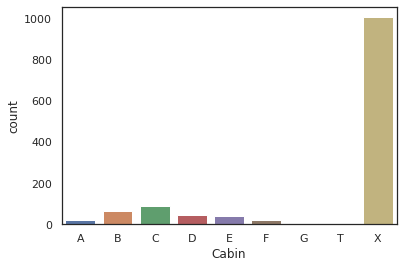

In [48]:
g = sns.countplot(dataset['Cabin'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


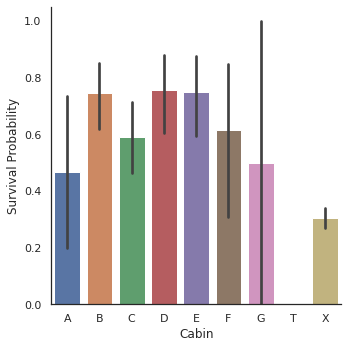

In [49]:
g = sns.factorplot(y = 'Survived', x = 'Cabin', data = dataset, kind = 'bar',
                  order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival Probability')

Cabin에서도 트기나 B, C, D, E, F같은 경우에는 유의미함

In [50]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

In [51]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

Ticket에서 앞쪽의 접두사가 비슷비슷하면 cabins가 똑같다고 볼 수 있음<br>
같은 prefix를 가진 Ticket은 비슷한 class와 비슷한 생존율을 보일 거 같다고 가정.

In [52]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.', '').replace('/','').strip().split(' ')[0])
    else:
        Ticket.append('X')
        
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [53]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix = 'T')
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')

In [54]:
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)